<a href="https://colab.research.google.com/github/labviros/computer-vision-topics/blob/version2020/lesson05-homography/sift_homography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homography Applications Examples

We are going to install OpenCV to use the homography function, as well the SIFT detector and some matching functions that are available at the OpenCV libraries. 

In [1]:
import numpy as np

#Rectifying a Document

In [2]:
def my_DLT(pts1: np.array, pts2: np.array) -> np.array:
  # Add homogeneous coordinates
  _, y = pts1.shape

  if y == 2:
    pts1 = np.column_stack((pts1, np.ones(len(pts1))))
    pts2 = np.column_stack((pts2, np.ones(len(pts2))))
  
  # Compute matrix A
  A = []
  for i in range(len(pts1)):
    A.append([0, 0, 0, -(pts2[i, 2]*pts1[i, 0]), -(pts2[i, 2]*pts1[i, 1]), -(pts2[i, 2]*pts1[i, 2]), pts2[i, 1]*pts1[i, 0], pts2[i, 1]*pts1[i, 1], pts2[i, 1]*pts1[i, 2]])
    A.append([pts2[i, 2]*pts1[i, 0], pts2[i, 2]*pts1[i, 1], pts2[i, 2]*pts1[i, 2], 0, 0, 0, -(pts2[i, 0]*pts1[i, 0]), -(pts2[i, 0]*pts1[i, 1]), -(pts2[i, 0]*pts1[i, 2])])
  

  # Perform SVD(A) = U.S.Vt to estimate the homography
  _, _, C = np.linalg.svd(A)

  
  # Reshape last column of V as the homography matrix
  H_matrix = C[-1].reshape((3,3))
  
  return H_matrix


def normalize_points(points):
    # Calculate centroid
    x_c, y_c = np.mean(points, axis=0)

    # Calculate the average distance of the points having the centroid as origin
    dist = 0
    for p in points:
      dist+= np.sqrt(np.power((x_c - p[0]), 2) + np.power((y_c - p[1]), 2))
    
    avr_dist = dist/len(points)

    # Define the scale to have the average distance as sqrt(2)
    scale = np.sqrt(2)/avr_dist
    
    # Define the normalization matrix (similar transformation)
    S = np.array([[scale, 0, 0],
                  [0, scale, 0],
                  [0,   0  , 1]])
    
    O = np.array([[1, 0, -x_c],
                  [0, 1, -y_c], 
                  [0, 0,   1 ]])
    
    T = np.dot(S, O)
    
    # Normalize points
    pts = np.column_stack((points, np.ones(len(points))))

    norm_pts = np.dot(T, pts.T).T
    
    return T, norm_pts

def my_homography(pts1,pts2):

    # Normalize points  
    T1, norm_pts1 = normalize_points(pts1)
    T2, norm_pts2 = normalize_points(pts2)
    
    # Perform DLT and obtan normalized matrix
    H_til = my_DLT(norm_pts1, norm_pts2)
    
    # Denormalize the homography matrix
    H = np.dot(np.linalg.inv(T2), np.dot(H_til, T1))
    
    return H

<Figure size 640x480 with 0 Axes>

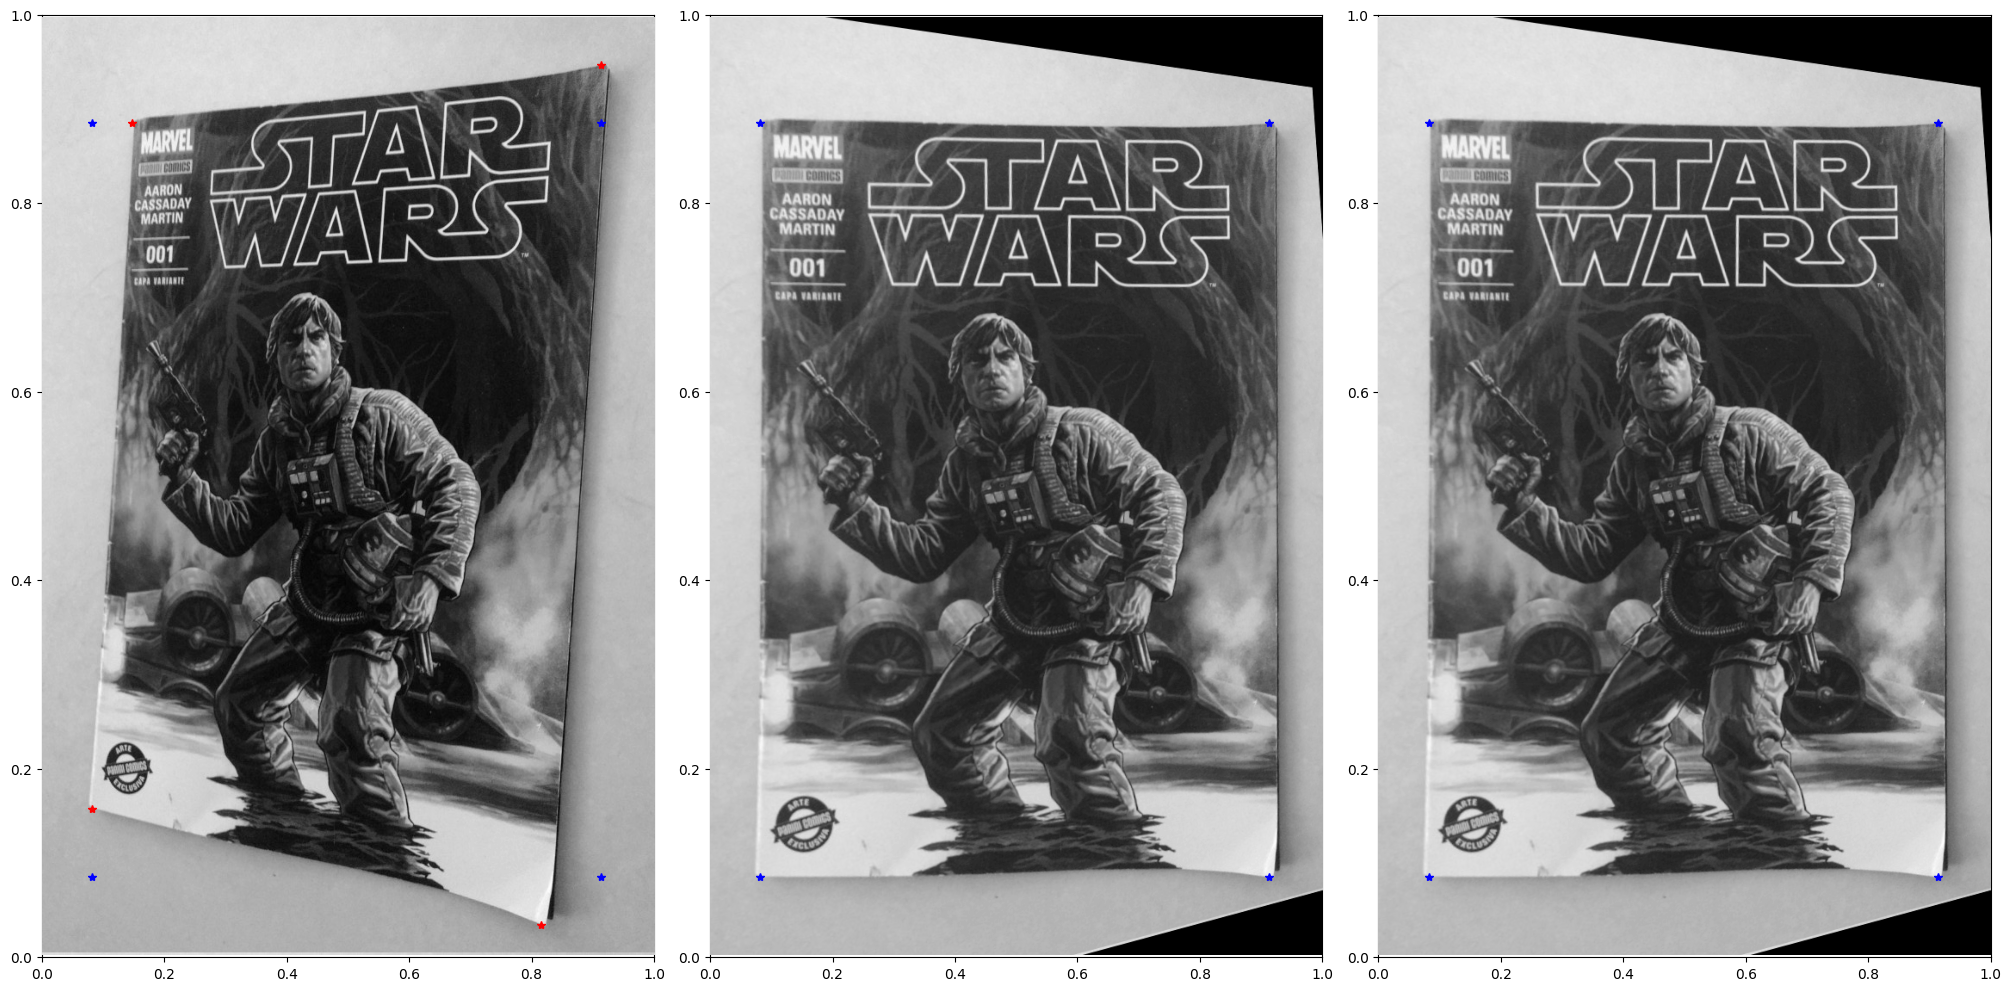

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
#import imutils
#import plotly.express as px
%matplotlib inline

### Setting printing options 
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.set_printoptions(precision=3,suppress=True)   


#MIN_MATCH_COUNT = 10
img1 = cv.imread('comicsStarWars02.jpg',0) # queryImage


corners_img1 = np.array([[105,123],[650,55],[580,1055],[58,920]])
corners_img2 = np.array([[58,123],[650,123],[650,1000],[58,1000]])

src_pts = np.float32(corners_img1)
dst_pts = np.float32(corners_img2)



#####################################################
# Substitute OpenCv function for your homography function

M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
H = my_homography(src_pts, dst_pts)
#####################################################


img4 = cv.warpPerspective(img1, M, (img1.shape[1],img1.shape[0])) #, None) #, flags[, borderMode[, borderValue]]]]	)
img5 = cv.warpPerspective(img1, H, (img1.shape[1],img1.shape[0]))

fig = plt.figure()
fig, axs = plt.subplots(1, 3, layout="constrained", figsize=(20,9.8))
ax1 = fig.add_subplot(1,3,1)
plt.imshow(img1, 'gray')
plt.axis('off')
plt.plot(corners_img2[:,0],corners_img2[:,1],'*b')
plt.plot(corners_img1[:,0],corners_img1[:,1],'*r')
ax2 = fig.add_subplot(1,3,2)
plt.axis('off')
plt.imshow(img4,'gray')
plt.plot(corners_img2[:,0],corners_img2[:,1],'*b')
ax2 = fig.add_subplot(1,3,3)
plt.imshow(img5,'gray')
plt.axis('off')
plt.plot(corners_img2[:,0],corners_img2[:,1],'*b')
plt.show()

#Using SIFT to estimate Homography between images and to warp the first image

<Figure size 640x480 with 0 Axes>

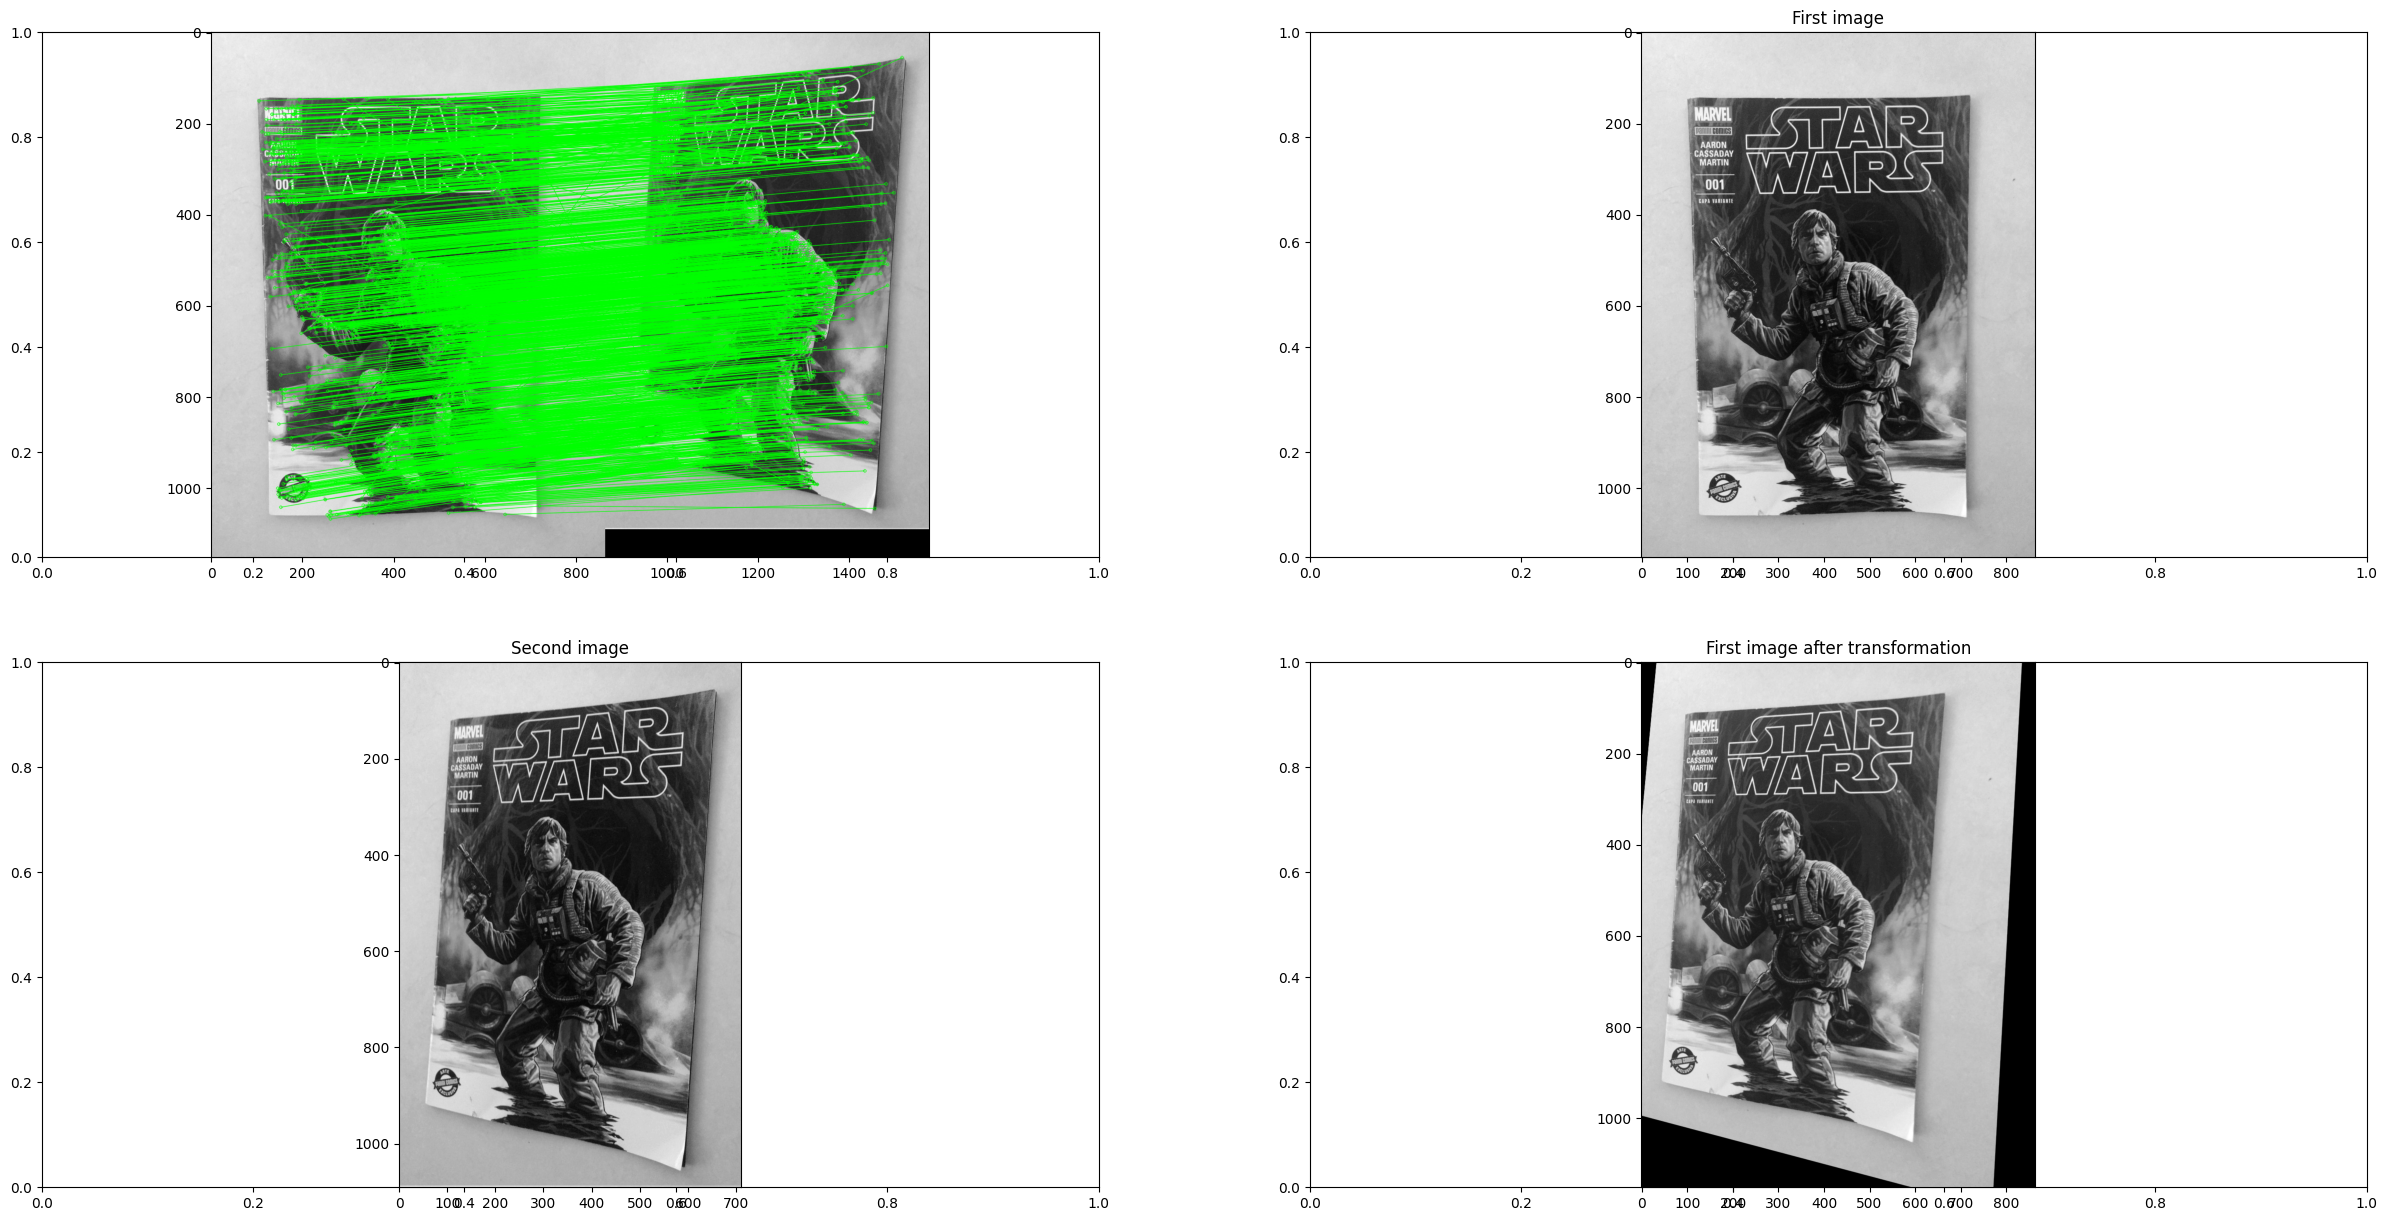

In [4]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
#import imutils

MIN_MATCH_COUNT = 10
img1 = cv.imread('comicsStarWars01.jpg',0)          # queryImage
img2 = cv.imread('comicsStarWars02.jpg',0) # trainImage

#img1 = imutils.rotate_bound(img1,180)

# Initiate SIFT detector
#sift = cv.xfeatures2d.SIFT_create()
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN stands for Fast Library for Approximate Nearest Neighbors. 
# It contains a collection of algorithms optimized for fast nearest neighbor 
# search in large datasets and for high dimensional features. 
# It works faster than BFMatcher for large datasets.
# The variable index_params specifies the algorithm to be used, its related parameters etc. 
# For algorithms like SIFT, SURF etc. you can pass following:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# The variable search_params specifies the number of times the trees in the index should 
# be recursively traversed. Higher values gives better precision, but also takes more time.
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
#bf = cv.BFMatcher()
#matches = bf.knnMatch(des1,des2,k=2)plt.imshow(img3, 'gray')



# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)


if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ])
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ])
    #M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    #matchesMask = mask.ravel().tolist()

    

    #####################################################
    # Substitute OpenCv function for your homography function

    #M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    M = my_homography(src_pts, dst_pts)
    #####################################################
    
    img4 = cv.warpPerspective(img1, M, (img1.shape[1],img1.shape[0])) #, None) #, flags[, borderMode[, borderValue]]]]	)


matchesMask = None
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)


fig = plt.figure()
fig, axs = plt.subplots(2,2,figsize=(30,15))
ax1 = fig.add_subplot(2,2,1)
plt.imshow(img3, 'gray')
ax1 = fig.add_subplot(2,2,2)
plt.title('First image')
plt.imshow(img1,'gray')
ax1 = fig.add_subplot(2,2,3)
plt.title('Second image')
plt.imshow(img2,'gray')
ax1 = fig.add_subplot(2,2,4)
plt.title('First image after transformation')
plt.imshow(img4,'gray')
plt.show()